##This notebook looks for which OTUs are significantly enriched or depleted as compared to the north sites. It considers each date separately.

In [16]:
%matplotlib inline
%load_ext rpy2.ipython
# Loading matplot Python library
# Loading the Rmagic extension

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in after plyr
library(ggplot2)
library(doParallel)

In [19]:
%%R
physeq = import_biom("OTU_table.biom", parseFunction = parse_taxonomy_greengenes)
# Importing the biom file as a phyloseq object, parsing its taxonomy as greengenes format

In [20]:
%%R
physeq
# Checking out the phyloseq object - we don't have the sample data added yet.

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 51928 taxa and 52 samples ]
tax_table()   Taxonomy Table:    [ 51928 taxa by 8 taxonomic ranks ]


In [21]:
%%R
sam.data <- read.csv(file="sample.data.csv", row.names=1, header=TRUE)
head(sam.data)
# Looking at the sample data file

       TreatmentGroup SampleSite Date                       Description
C172N1          Early      North J172 Sample of day 172 at site North 1
C172N2          Early      North J172 Sample of day 172 at site North 2
C172N3          Early      North J172 Sample of day 172 at site North 3
C172P1          Early      Point J172 Sample of day 172 at site Point 1
C172P2          Early      Point J172 Sample of day 172 at site Point 2
C172P3          Early      Point J172 Sample of day 172 at site Point 3


In [22]:
%%R
sample_data(physeq) <- sam.data
physeq
#Now we have added the sample data to the phylosq object.

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 51928 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 4 sample variables ]
tax_table()   Taxonomy Table:    [ 51928 taxa by 8 taxonomic ranks ]


In [23]:
%%R
sample.summary <- data.frame(sample_data(physeq)) %>%
    group_by(SampleSite,Date) %>%
    summarize(total=n())
sample.summary
# Takes the sample data we just connected to the phyloseq file, in the form of a dataframe,
# Groups it by each combination of sample site and date
# reports the total number of samples we have for each site/date combo - we have 2-3 samples for each.

Source: local data frame [18 x 3]
Groups: SampleSite

   SampleSite Date total
1       North J172     3
2       North J178     3
3       North J185     3
4       North J199     3
5       North J206     3
6       North J214     3
7       Point J172     3
8       Point J178     3
9       Point J185     3
10      Point J199     3
11      Point J206     2
12      Point J214     3
13      South J172     3
14      South J178     3
15      South J185     3
16      South J199     3
17      South J206     2
18      South J214     3


In [24]:
%%R
# Creating a matrix with the different combinations of variables for samplesite and date
variables = expand.grid(SampleSite=c("Point","South"),Date=c("J172","J178","J185","J199","J206","J214"))
variables

   SampleSite Date
1       Point J172
2       South J172
3       Point J178
4       South J178
5       Point J185
6       South J185
7       Point J199
8       South J199
9       Point J206
10      South J206
11      Point J214
12      South J214


In [25]:
%%R
Date = "J178"
SampleSite = "Point"
physeq.pruned = prune_samples((sample_data(physeq)$Date == Date & ((sample_data(physeq)$SampleSite == SampleSite) | (sample_data(physeq)$SampleSite == "North"))),physeq)
sample_data(physeq.pruned)

Sample Data:        [6 samples by 4 sample variables]:
       TreatmentGroup SampleSite Date                       Description
C178N1          Early      North J178 Sample of day 178 at site North 1
C178P1          Early      Point J178 Sample of day 178 at site Point 1
C178P2          Early      Point J178 Sample of day 178 at site Point 2
C178P3          Early      Point J178 Sample of day 178 at site Point 3
C178N3          Early      North J178 Sample of day 178 at site North 3
C178N2          Early      North J178 Sample of day 178 at site North 2


In [26]:
%%R
# We are creating a function called Dif_Abund that will run deseq on each subset of factors (day and samplesite), 
# and return the factors, OTU ID, base mean, log2-fold change, the SE, and the p value associated with the response.

# This is testing for the question, on each date, are there differences between sample sites?

Dif_Abund = function(SampleSite,Date){
    physeq.pruned = prune_samples(sample_data(physeq)$Date == paste(Date),physeq)
    physeq.pruned = prune_samples((sample_data(physeq.pruned)$SampleSite == paste(SampleSite) | sample_data(physeq.pruned)$SampleSite == "North"),physeq.pruned)
# Pulling out the samples we want to compare - we will run DESeq for each date. So, we pull out the rows from the site we are interested in,
# and then also the baseline location (North) for that day, from our physeq object.
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
# Cutting out any OTUs that don't show up in this comparison
    taxonomy <- data.frame(tax_table(physeq.pruned))
# Storing the taxonomy data
    dseq = phyloseq_to_deseq2(physeq.pruned, ~SampleSite)
# Creating the dseq file, and using the formula that tells it we are interested in samplesite as a factor, and date as the baseline.
    dseq$SampleSite = relevel(dseq$SampleSite,"North")
# Establishing that the baseline comparison is for the first day.
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
# Running the actual DESeq function
    results = results(dseq, cooksCutoff=TRUE)
# Reporting the results from the dseq object we just created
# You can change Cooks Cutoff to control outliers (TRUE) or not (FALSE)
    results$Date = Date
    results$SampleSite = SampleSite
# Creates a column in the results dataframe listing the SampleSite
    results = data.frame(results$SampleSite,results$Date,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
# Pulling out all the results we are actually interested in
    colnames(results) = c("SampleSite","Date","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
# Naming the columns appropriately
    results
# Return the final results dataframe
    }

In [27]:
%%R
DA<-mdply(variables,Dif_Abund)
# Runs the  differential abundance function we created above on all the combinations of variables
# We are leaving out the first variable, because that is the comparison baseline.
# The formula, as written above, will not tell us if the sites are different from one to the next
# It is looking for OTUs that are increased in relative abundance (compared to the first sampling day)
# across all sites, but accounting for the fact that the sites have different baselines, basically.

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [28]:
%%R
threshold = function (thresh){
    filter(DA, baseMean >= thresh) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>%
    summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Creates a function called "threshold" that will take our DA table as created above, then filter it so that we only keep
# rows where the baseMean (roughly the relative abundance for that OTU) is greater than some threshold, "thresh"
# Then, for those remaining rows, we run a Benjamini-Hochberg correction on our p-values, outputting these adjusted
# values in a new colum ("padj")
# Finally, we report back the threshold, and then the sum of taxa for which we have adjusted p values
# less than or equal to 0.10, our chosen false discovery rate

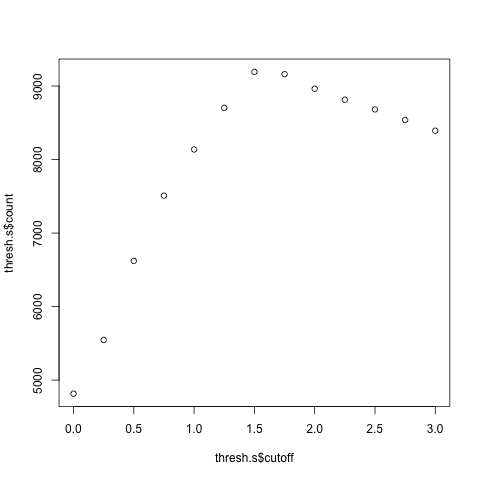

In [29]:
%%R
range = seq(0,3,0.25)
# Creates a sequence of numbers we are interested in for adjusted p values (from 0-3 by 0.25 increments)
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 1.5)

In [30]:
%%R
head(DA)

  SampleSite Date             OTU  baseMean       l2FC       SE    pvalue
1      Point J172 KC886811.1.1420 4.8294348 -1.3492579 1.218346 0.2680992
2      Point J172 FJ612183.1.1494 0.6042823  0.2782672 2.170365 0.8979811
3      Point J172 FJ382737.1.1359 0.1174397 -1.0534556 2.209295 0.6334840
4      Point J172 AM419442.1.1418 3.0700766 -2.0669439 1.871343 0.2693657
5      Point J172 AF368182.1.1369 0.5315318  2.7206376 2.213070 0.2189406
6      Point J172   E32645.1.1435 3.3507768 -1.4639187 1.344574 0.2762595
   Kingdom         Phylum               Class              Order
1 Bacteria  Bacteroidetes      Flavobacteriia   Flavobacteriales
2 Bacteria Proteobacteria  Betaproteobacteria    Burkholderiales
3 Bacteria  Cyanobacteria         Chloroplast      Stramenopiles
4 Bacteria Proteobacteria Deltaproteobacteria Desulfovibrionales
5 Bacteria Proteobacteria Alphaproteobacteria    Rhodobacterales
6 Bacteria  Cyanobacteria         Chloroplast        Chlorophyta
               Family      

In [31]:
%%R
group_by(DA, SampleSite, Date) %>%
    filter(baseMean>=1.5) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("l2fcSitesxDates.csv", row.names=FALSE)
# We take that differential abundance table we created above ("DA"), and take the sum of the baseMean for each date
# Then we filter the whole set of values to include only those OTUs for which their baseMean was >1.5,
# We then adjust the p values only for those that we expect might be significant.
# I.e., those of very low relative abundance in the first place are not getting assessed at all,
# Allowing us to not test their significance - so untestested values will have NA in the padj column.
# Then we save it as a csv.

In [32]:
%%R
l2fc<-read.csv("l2fcSitesxDates.csv")
# Import that csv file we just saved
dim(l2fc[is.na(l2fc$padj)==TRUE,])[1]/dim(l2fc[])[1]
# Fraction of OTUs that were not tested for significance (padj is "NA")
# We didn't actually cut it down that much, but it might help.

[1] 0.01708261


In [33]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    group_by(SampleSite,Date)%>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    group_by(SampleSite,Date)%>%
    count(SampleSite,Date,Sig)%>%
    group_by(SampleSite,Date)%>%
    mutate(Fraction=n/sum(n))
d
# Creates a little table showing which fraction of OTUs were designated as significant or not on each date
# A good number are - 10-30%

Source: local data frame [24 x 5]
Groups: SampleSite, Date

   SampleSite Date Sig    n   Fraction
1       Point J172   0 2313 0.92742582
2       Point J172   1  181 0.07257418
3       Point J178   0 1749 0.84329797
4       Point J178   1  325 0.15670203
5       Point J185   0 1670 0.80404429
6       Point J185   1  407 0.19595571
7       Point J199   0 1807 0.78839442
8       Point J199   1  485 0.21160558
9       Point J206   0 2819 0.88759446
10      Point J206   1  357 0.11240554
..        ...  ... ...  ...        ...


In [34]:
%%R 
FDR = 0.1
d = l2fc

d = group_by(d, SampleSite,Date) %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    mutate(Total=sum(baseMean)) %>%
    mutate(relabund=baseMean/Total)%>%
    filter(padj != 'NA')
# Creates a column designating whether (1) or not (0) the padj is lower than our false discovery rate (set above)
# We also calculate a new relative abundance value using the average across samples
# and we cut out those rows with no p-values

PhylumFraction = 0.005
OTUFraction = 0.001
PhylumList = d %>%
    group_by(Phylum,Date)%>%
    filter(sum(relabund)>=PhylumFraction | relabund>=OTUFraction)
PhylumList = levels(droplevels(PhylumList$Phylum))
# Looks at each phylum, on each date, and sees if the total abundance of OTUs within that phylum is
# greater than the cutoff (PhylumFraction, defined above), OR if the single OTU makes up a large enough fraciton
# of the total community on its own (OTUFraction, defined above)
# Thus, we have selected the phyla we want to plot.

d = filter(d, Phylum %in% PhylumList)
    
max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# makes a dataframe with the maximum value of log2Fold change for each phylum
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$sig = as.factor(d$sig)
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
# Creates new columns (true/false) for whether it is significant or not

##Let's take a look at how relative abundance changes over time (in all 3 sites combined) within each phylum

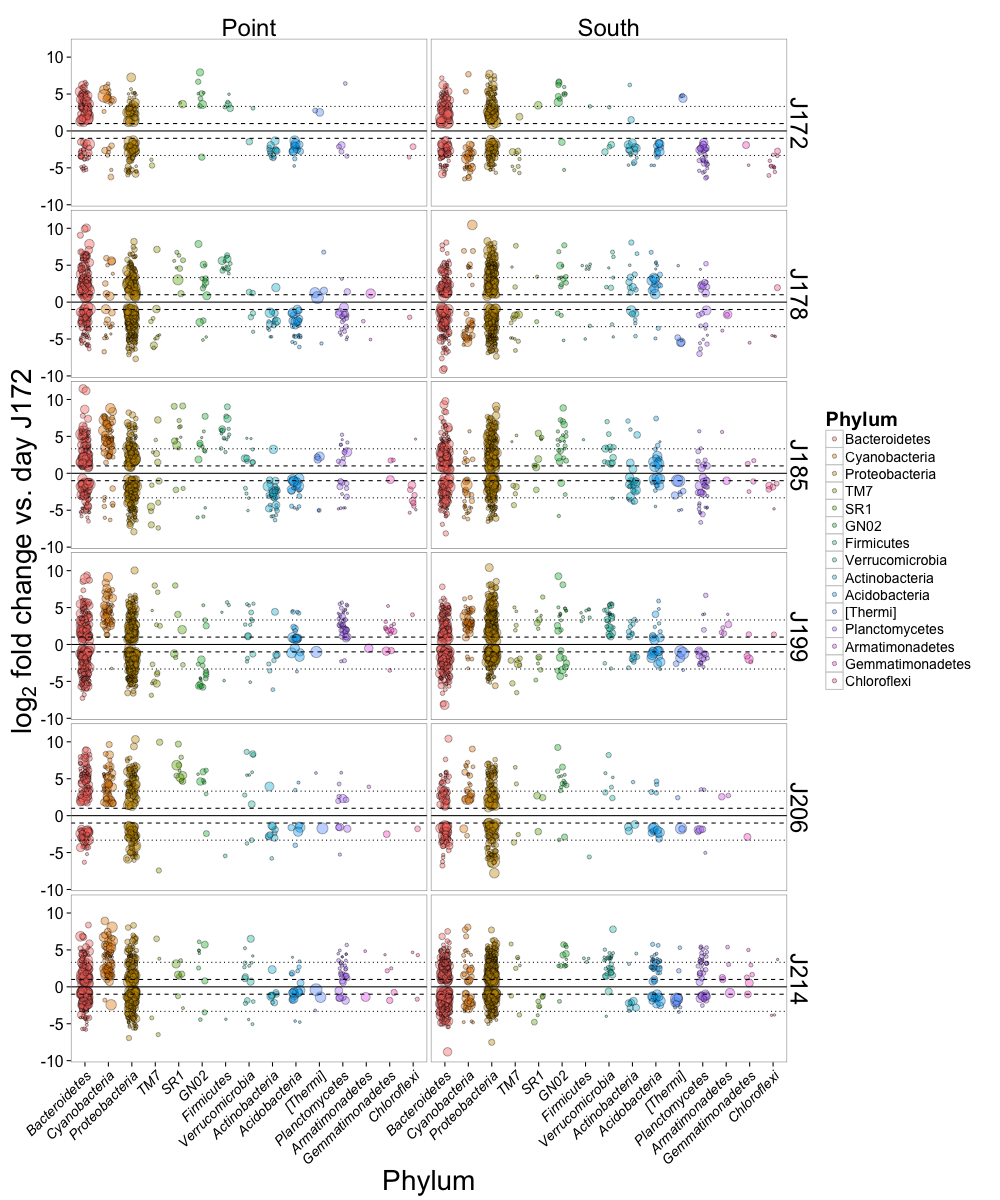

In [35]:
%%R -w 1000 -h 1200
# setting the image sizes, then making the figure...

p = ggplot(d)
p = p + geom_point(data=d.yes, aes(x = Phylum, y = l2FC, fill = Phylum, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
# p = p + geom_point(data=d.no, aes(x = Date, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_grid(Date~SampleSite, scales="free_x")
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes.
    
p

##The Proteobacteria and Bacteroidetes are too rich to really see clearly at the phylum level, so we plot them out below

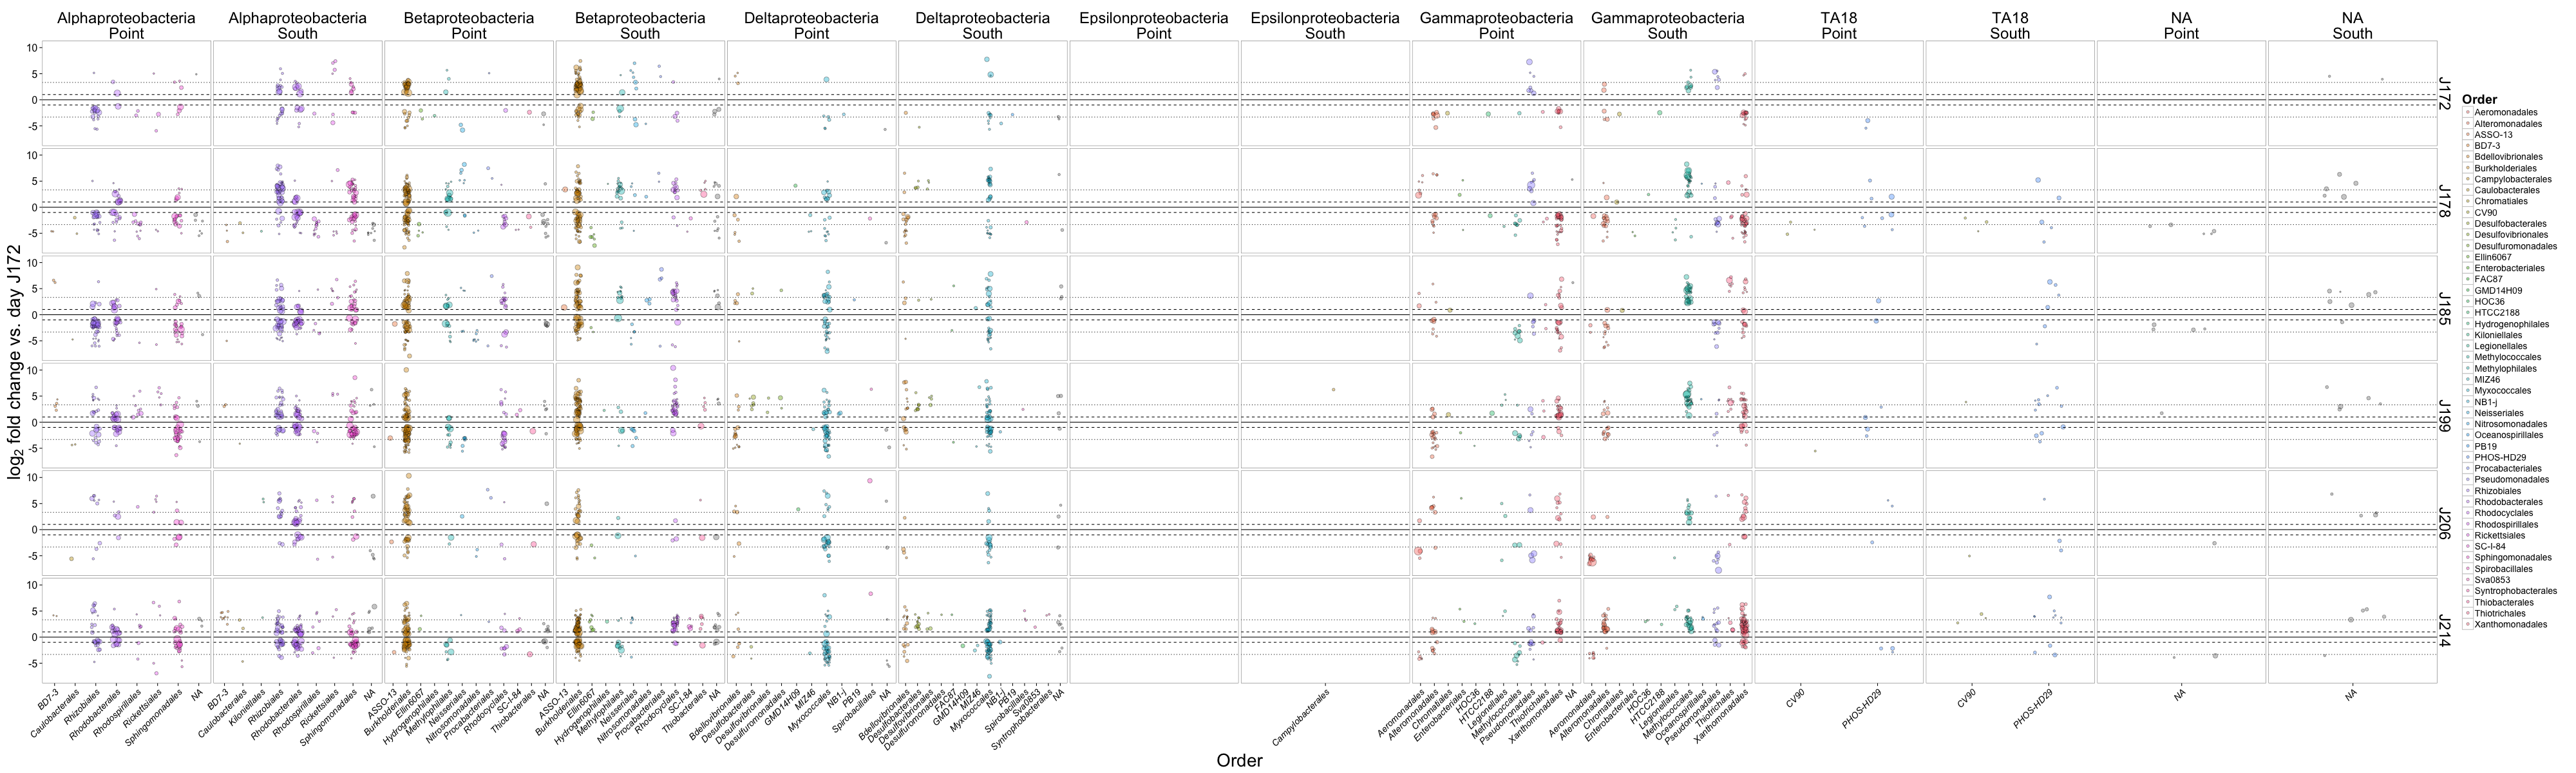

In [36]:
%%R -w 4000 -h 1200
# setting the image sizes, then making the figure...

dProteo = d %>%
    filter(Phylum=="Proteobacteria")
d.yesProteo = d.yes %>%
    filter(Phylum=="Proteobacteria")
d.noProteo = d.no %>%
    filter(Phylum=="Proteobacteria")
# Subsetting our data for Proteos

p = ggplot(dProteo)
p = p + geom_point(data=d.yesProteo, aes(x = Order, y = l2FC, fill = Order, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
# p = p + geom_point(data=d.noProteo, aes(x = Date, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_grid(Date~Class+SampleSite, scales="free_x")
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes.
    
p

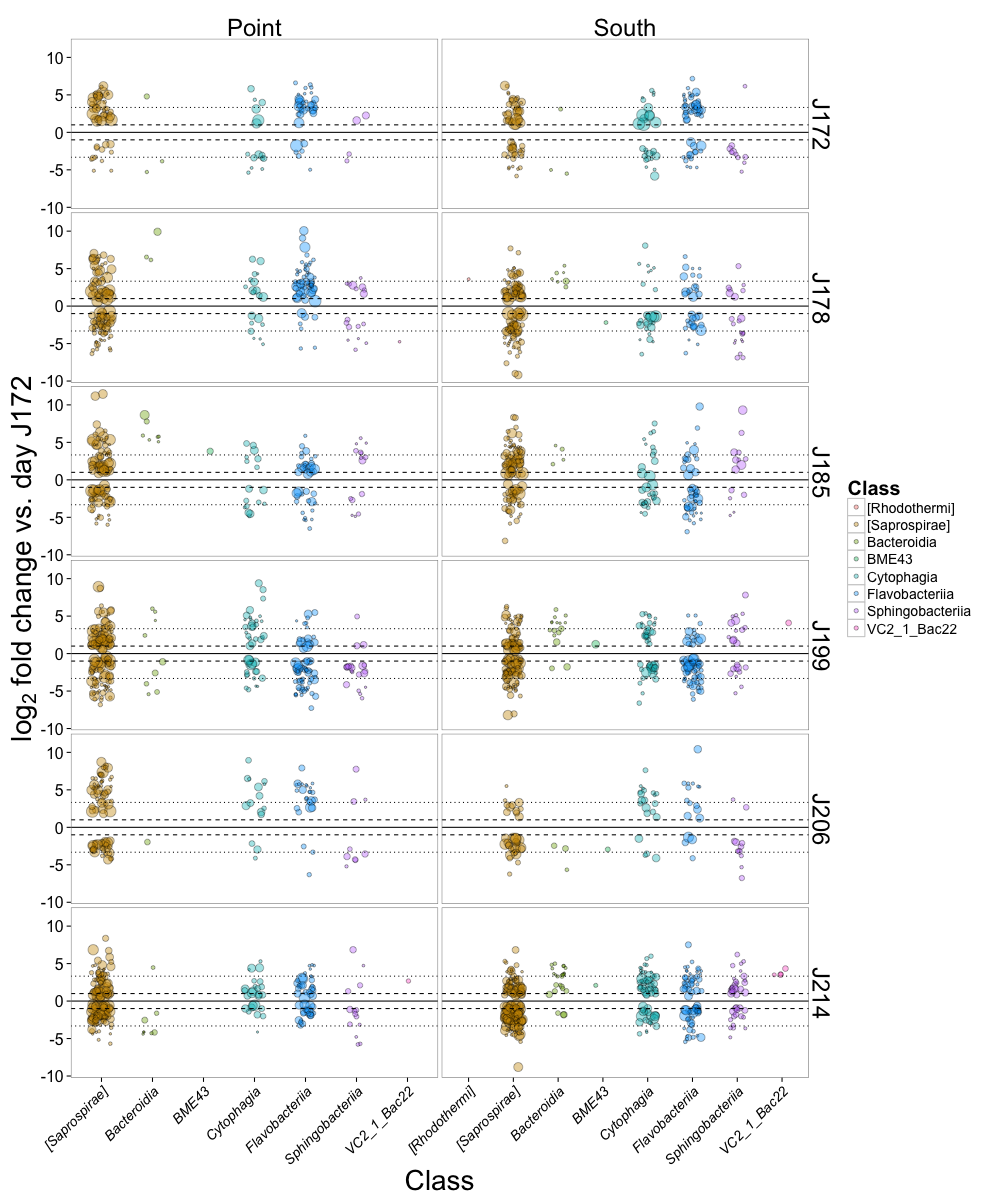

In [37]:
%%R -w 1000 -h 1200
# setting the image sizes, then making the figure...
dBacter = d %>%
    filter(Phylum=="Bacteroidetes")
d.yesBacter = d.yes %>%
    filter(Phylum=="Bacteroidetes")
d.noBacter = d.no %>%
    filter(Phylum=="Bacteroidetes")

p = ggplot(dBacter)
p = p + geom_point(data=d.yesBacter, aes(x = Class, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
#p = p + geom_point(data=d.noBacter, aes(x = Class, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_grid(Date~SampleSite, scales="free_x")
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes.
    
p

##What about the methanos? Are any significantly increased over time?

In [41]:
%%R
# Find methanotrophs
methanolist <- read.table(file = "methanos.txt")
methanolist <- as.vector(methanolist$V1)
# Create a list of all the possible methanotroph genera
df = l2fc %>%
 filter(Genus %in% as.factor(methanolist))
# Take out only the methanotrophs

In [43]:
%%R
df = group_by(df, SampleSite,Date) %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    mutate(Total=sum(baseMean)) %>%
    mutate(relabund=baseMean/Total)%>%
    filter(padj != 'NA')
# Creates a column designating whether (1) or not (0) the padj is lower than our false discovery rate (set above)
# We also calculate a new relative abundance value using the average across samples
# and we cut out those rows with no p-values

df$sig = as.factor(df$sig)
df.yes = df[df$sig==1,]
df.no = df[df$sig==0,]
# Creates new columns (true/false) for whether it is significant or not

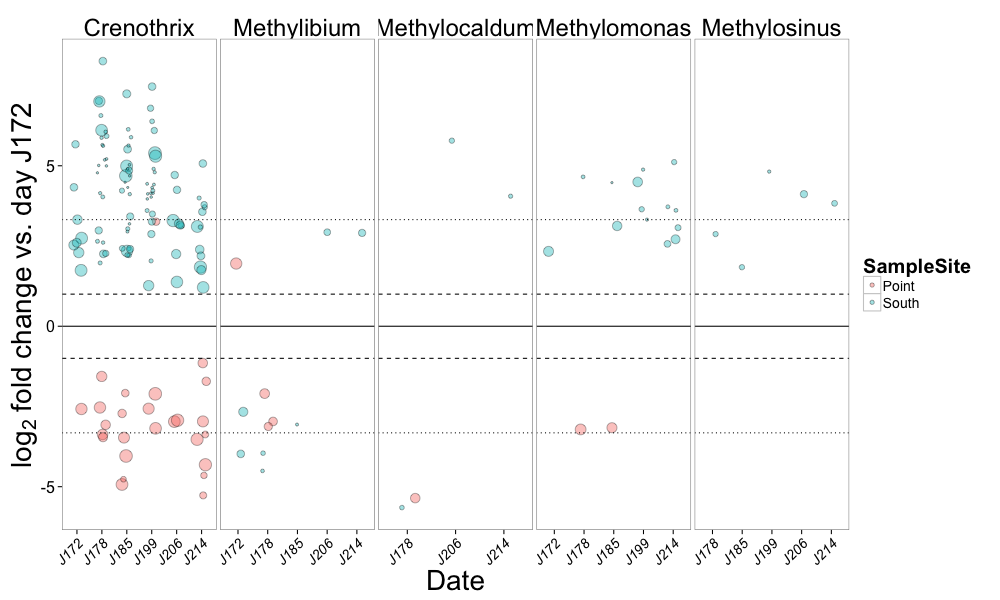

In [54]:
%%R -w 1000 -h 600

p = ggplot(df)

p = p + geom_point(data=df.yes, aes(x = Date, y = l2FC, fill = SampleSite, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
#p = p + geom_point(data=d.noBacter, aes(x = Class, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
# Plotting the significant and the nonsignificant points differently
# size is proportional to relative abundance, and we colour it by Class

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
# Transforming the size of the points so it's better visualized

p = p + facet_grid(~Genus, scales="free_x")
# Saying we want it to present the data separately for each phylum

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# Puts in horizontal lines at reference values

p = p + theme_bw()
# Sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text

p = p + labs(y = expression(paste("", log[2]," fold change vs. day J172",sep="")))
# sets the label for the y axes

p 

##The figure above is basically showing whether a given suspected methanotroph was relatively enriched compared to the North sites on a given day. We can see that Crenothrix seems to be consistently enriched at the South site, but depleted at the point, compared to the North - perhaps some gradient is at play.
##Note, though, that this does not ask whether methanotrophs change over time. That is in the Dates sheet.